## Install software
Please make sure you only run this cell at the correct stage of the setup. 

You can run a code cells by bringing it into focus (e.g. clicking in it) and pressing "ctrl+Enter".

In [1]:
import sys
# !python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !python -m pip install -U scikit-learn
!python -m pip install pandas
# !python -m pip install -U matplotlib
# !python -m pip install opencv-contrib-python

  Using cached pandas-2.3.1-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp311-cp311-win_amd64.whl (11.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -

## Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from PIL import Image
import cv2
import io
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

c:\ProgramData\anaconda3\envs\wexenv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda


## Download dataset
Run the following code cell to download and prepare the MNIST datasets.

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 3817894.22it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 370259.85it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3207936.75it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1513989.41it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



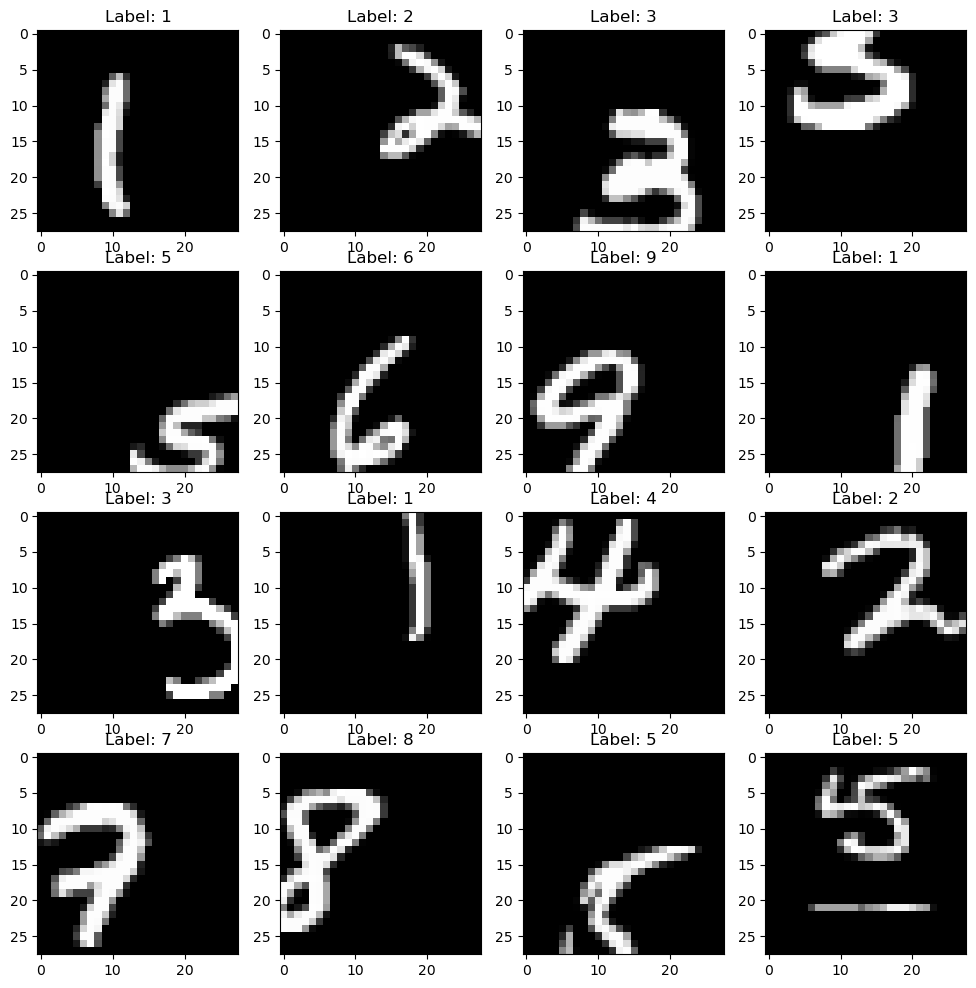

In [3]:
class PadTranslateCrop:
    def __init__(self, pad, translate_px):
        self.pad = pad
        self.translate_px = translate_px

    def __call__(self, img):
        # Pad the image
        img = transforms.functional.pad(img, self.pad, fill=0)
        # Translate the image
        dx = torch.randint(-self.translate_px, self.translate_px + 1, (1,)).item()
        dy = torch.randint(-self.translate_px, self.translate_px + 1, (1,)).item()
        img = transforms.functional.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0, fill=0)
        # Crop back to original size
        w, h = img.size
        left = (w - 28) // 2
        top = (h - 28) // 2
        img = transforms.functional.crop(img, top, left, 28, 28)
        return img

# Usage in your transform pipeline
custom_transform = transforms.Compose([
    PadTranslateCrop(pad=14, translate_px=10),  # pad and allow up to 10px translation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and prepare the training and test datasets
data_train = datasets.MNIST(root='./data', train=True, download=True, transform=custom_transform)
data_test = datasets.MNIST(root='./data', train=False, download=True, transform=custom_transform)

# Set the split sizes
train_size = int(0.8 * len(data_train))
val_size = len(data_train) - train_size

# Split the dataset
train_subset, val_subset = random_split(data_train, [train_size, val_size])

### Plot sample of images
sample_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
# Get a batch of images and labels from the train_loader
images, labels = next(iter(sample_loader))
# Plot the first 8 images in the batch
plt.figure(figsize=(12, 12))
for i in range(labels.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i, 0].cpu().numpy(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")

## Set hyperparameters

In [ ]:
### Parameters to be modified
batchSize = 1 # Number of samples used to update the model parameters each iteration
learningRate = 0.1 # Determines how quickly the model learns
num_episodes = 10000 # How many times we update the model parameters

## Create Convolutional Neural Network model

In [ ]:
# Define a convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2) # 28 input, 28 output
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, padding=2, stride=2) # 28 input, 14 output
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 14 input, 14 output (+pool -> 7 output)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 7 input, 7 output (+pool -> 3 output)
        self.conv5 = nn.Conv2d(128, 10, kernel_size=3, padding=0) # 3 input, 1 output (+pool -> 1 output)

    def forward(self, x):
        x = torch.relu(self.conv1(x)) # 28 input, 28 output
        # x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x)) # 28 input, 14 output
        # x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x)) # 14 input, 14 output (+pool -> 7 output)
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x)) # 7 input, 7 output (+pool -> 3 output)
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv5(x)) # 3 input, 1 output (+pool -> 1 output for each class) 
        # x = x.squeeze(-1)  # Now shape is (batch_size, number of classes)
        x = x.view(x.size(0), -1) # Flatten the output to (batch_size, number of classes)
        return x

# Create the model and setup the loss and optimiser
model = CNN().to(device) # Create model and move to GPU
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=learningRate) # Optimiser

## Train the Neural Network to classify digits

In [ ]:

# Initialise arrays for recording performance
train_losses = []
val_losses = []
train_acc = []
val_acc = []
sm_train_losses = []
sm_val_losses = []
sm_train_acc = []
sm_val_acc = []
nSmooth = 50 # Number of episodes to average over for smoothing

# Prepare Dataloaders and iterator to sample from dataset
# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batchSize, shuffle=False)
# Iterator
train_iter = iter(train_loader)
val_iter = iter(val_loader)

for episode in range(num_episodes):
    # Get next batch, restart if reaches end of dataset
    try:
        train_data = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        train_data = next(train_iter)
    try:
        val_data = next(val_iter)
    except StopIteration:
        val_iter = iter(val_loader)
        val_data = next(val_iter)

    # Training step
    model.train()
    images, labels = train_data[0].to(device), train_data[1].to(device) # Extract input images and class labels from training set
    optimizer.zero_grad() # Reset gradients
    outputs = model(images) # Forward pass
    outputs = outputs.squeeze(-1)  # compress outputs from nBatch x nClass x 1 to nBatch x nClass
    loss = criterion(outputs, labels) # Compute loss
    loss.backward() # Backward pass: calculate gradients
    optimizer.step() # Update model parameters
        
    # Calculate classification accuracy
    _, predicted = torch.max(outputs.detach(), 1)  # Detach outputs before using for accuracy
    correct = (predicted == labels).sum().item() # Sum number of correct predictions
    accuracy = correct / labels.size(0) * 100.0 # Calculate percentage accuracy

    # Add loss and accuracy to records
    train_losses.append(loss.item()) 
    train_acc.append(accuracy) 

    # Validation step
    model.eval()
    with torch.no_grad():
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device) # Extract input images and class labels from validation set
        val_outputs = model(val_images) # Forward pass
        val_outputs = val_outputs.squeeze(-1)  # compress outputs from nBatch x nClass x 1 to nBatch x nClass
        val_loss = criterion(val_outputs, val_labels) # Compute validation loss
        val_losses.append(val_loss.item())
        _, val_predicted = torch.max(val_outputs.detach(), 1) # Detach val_outputs before using for accuracy
        val_correct = (val_predicted == val_labels).sum().item()
        val_accuracy = val_correct / val_labels.size(0) * 100.0
        val_acc.append(val_accuracy)

    # Update smooth loss and accuracy curves for plotting
    if len(train_losses) > nSmooth:
        sm_train_losses.append(numpy.mean(train_losses[-nSmooth:]))
        sm_val_losses.append(numpy.mean(val_losses[-nSmooth:]))
        sm_train_acc.append(numpy.mean(train_acc[-nSmooth:]))
        sm_val_acc.append(numpy.mean(val_acc[-nSmooth:]))

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes}:")
        print(f"    Train Loss: {sm_train_losses[-1]:.4f} | Val Loss: {sm_val_losses[-1]:.4f}")
        print(f"    Train Accuracy: {sm_train_acc[-1]:.2f} | Val Accuracy: {sm_val_acc[-1]:.2f}")

# Open figure with subplots for plotting loss and accuracy curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) 
# Plot losses
ax1.plot(train_losses, label='Train Loss', color=(0.4, 0.7, 1.0)) # Actual train losses
ax1.plot(val_losses, label='Val Loss', color=(1.0, 0.7, 0.4)) # Actual validation losses
ax1.plot(sm_train_losses, label='Smoothed Train Loss', color=(0., 0.2, 0.6)) # Smoothed train losses
ax1.plot(sm_val_losses, label='Smoothed Val Loss', color=(0.6, 0.2, 0.)) # Smoothed validation losses
ax1.set_xlabel('Episode')
ax1.set_ylabel('Loss')
ax1.legend()
# Plot accuracies
ax2.plot(train_acc, label='Train Accuracy', color=(0.4, 0.7, 1.0)) # Actual train accuracies
ax2.plot(val_acc, label='Val Accuracy', color=(1.0, 0.7, 0.4)) # Actual validation accuracies
ax2.plot(sm_train_acc, label='Smoothed Train Accuracy', color=(0., 0.2, 0.6)) # Smoothed train accuracies
ax2.plot(sm_val_acc, label='Smoothed Val Accuracy', color=(0.6, 0.2, 0.)) # Smoothed validation accuracies
ax2.set_xlabel('Episode')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
plt.show()

## Save your trained model

In [ ]:
### Save your trained model
torch.save(model.state_dict(), './model_trained')

## Visualise how well your Neural Network classifies digits

In [ ]:
### Plot sample of images
sample_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
# Get a batch of images and labels from the train_loader
images, labels = next(iter(sample_loader))

# Load model
model = CNN()
model.load_state_dict(torch.load('./model_trained'))
model.to(device)  # Move model to GPU if available
model.eval()

# Get neural network predictions
with torch.no_grad():
    outputs = model(images.to(device))
    outputs = outputs.squeeze(-1)  # compress outputs from nBatch x nClass x 1 to nBatch x nClass
    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities

# Plot 16 samples
import matplotlib.gridspec as gridspec

num_samples = 16  # Number of images to show
num_cols = 4     # Images per row
num_img_rows = (num_samples + num_cols - 1) // num_cols  # Number of image rows
num_total_rows = num_img_rows * 2  # Each image row followed by a bar chart row

fig = plt.figure(figsize=(10, 2 * num_total_rows))
# Height ratios: image rows = 3, bar chart rows = 1 (one third height)
gs = gridspec.GridSpec(num_total_rows, num_cols, height_ratios=[3, 1] * num_img_rows)

for idx in range(num_samples):
    row_img = (idx // num_cols) * 2      # Odd-numbered row for image
    col = idx % num_cols
    row_bar = row_img + 1                # Even-numbered row for bar chart

    # Image subplot
    ax_img = fig.add_subplot(gs[row_img, col])
    ax_img.imshow(images[idx, 0].cpu().numpy(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f"Label: {labels[idx].item()}\nPred: {probabilities[idx].argmax().item()}", fontsize=10)

    # Bar chart subplot (same width, half height)
    ax_bar = fig.add_subplot(gs[row_bar, col])
    ax_bar.bar(numpy.arange(10), probabilities[idx].cpu().numpy())
    ax_bar.set_xticks(numpy.arange(10))
    ax_bar.set_ylim(0, 1)
    ax_bar.set_title("Class Probabilities", fontsize=9)
    ax_bar.tick_params(axis='x', labelsize=8)
    ax_bar.tick_params(axis='y', labelsize=8)

    # Optional: Remove y-axis for cleaner look
    ax_bar.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Inspect the learned filters in layers 1 and 2

In [ ]:
# Visualize the 16 filters in the first convolutional layer
filters1 = model.conv1.weight.data.cpu().numpy()  # Shape: (16, 1, 5, 5)

# Plot the first 16 filters in the first convolutional layer
# Each filter is a 5x5 image, and we will plot them in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
fig.suptitle("First Layer Filters (conv1)", fontsize=14)
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(filters1[i, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Filter {i+1}', fontsize=8)
plt.tight_layout()
plt.show()

## Process the video feed and display feedback
### Filter video feed
```custom_filter()```

This filter makes the video feed look more similar to the images used to train the model. It applies several different filters in the following sequence:

1. turns the colour image to grayscale
2. applies an adaptive threshold, turning light areas black, and dark areas white
3. applies a smoothing effect
4. applies another adaptive filter to increase contrast
5. crops the video feed to capture a central square region
6. adjusts the mean brightness and contrast

### Plot a bar chart showing the neural network's predictions
```dynamic_barchart()```

This function creates a barchart, like those shown above, which updates with every frame of the video feed to show the neural network's predictions in real time.


In [ ]:
def custom_filter(input_image):
    # Convert to grayscale
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold to remove uneven background
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 27, 5
    )

    # Apply Gaussian blur with sigma=1 (ksize=0 lets OpenCV compute from sigma)
    blur = cv2.GaussianBlur(thresh, (0, 0), sigmaX=2)

    # Adaptive threshold to remove uneven background
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 27, 1
    )

    # Process frame to be greyscale and same shape as training images
    image = cv2.resize(thresh[:,80:560], (28, 28), interpolation=cv2.INTER_AREA)/255.0
    output_image = (image - 0.1307) / 0.3081  # Normalize the image as per training data

    return output_image

def dynamic_barchart(probabilities):
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.bar(numpy.arange(10), probabilities)
    ax.set_ylim(0, 1)
    ax.set_title("Prediction Probabilities")
    ax.set_xlabel("Digit")
    ax.set_ylabel("Probability")
    ax.set_xticks(numpy.arange(10))  # Ensure tick marks for every integer 0-9
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    bar_img = numpy.frombuffer(buf.getvalue(), dtype=numpy.uint8)
    bar_img = cv2.imdecode(bar_img, 1)

    return bar_img

## Run webcam through model
To stop the webcam, press q

In [ ]:
### Open the first webcam (index 0)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Create OpenCV window
cv2.namedWindow("Webcam", cv2.WINDOW_NORMAL) 
# Resize window 
cv2.resizeWindow("Webcam", 640+480, 480) 
#########################################

model = CNN()
model.load_state_dict(torch.load('./model_trained'))
model.to(device)  # Move model to GPU if available
model.eval()

##########################################

# Loop to capture frames from the webcam
while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Check if frame is successfully read
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Apply filter to video feed
    filtered_image = custom_filter(frame)

    # Forward pass through model to get class predictions
    with torch.no_grad():
        output = model(torch.tensor(numpy.reshape(filtered_image,(1,1,28,28))).float().to(device))
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy().flatten()  # Get probabilities
    

    ### Build feedback display
    # Prepare filtered_image for display
    image_disp = ((filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min()) * 255).astype(numpy.uint8)
    image_disp = cv2.cvtColor(cv2.resize(image_disp, (480, 480)), cv2.COLOR_GRAY2BGR)
    # Concatenate original and normalised images horizontally
    top_row = cv2.hconcat([frame, image_disp])
    # Create bar chart
    bar_img = dynamic_barchart(probabilities)
    # Pad norm_disp to match frame_disp height
    pad = (top_row.shape[1] - bar_img.shape[1]) // 2
    bar_disp = cv2.copyMakeBorder(bar_img, 0, 0, pad, top_row.shape[1] - bar_img.shape[1] - pad, cv2.BORDER_CONSTANT, value=0)
    # Stack vertically
    combined = cv2.vconcat([top_row, bar_disp])
    # Display the combined image
    cv2.imshow('Webcam', combined)

    # Check for 'q' key to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
